In [80]:
%matplotlib inline
import glob
import numpy as np
import threading
import bcolz
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

In [60]:
fnames = list(glob.iglob('/home/ramsus/Qt/computer_vision_dataset/imagenet/ILSVRC2012_img_train/*/*.JPEG'))
print(len(fnames))

1281167


In [9]:
print(fnames[0])

/home/ramsus/Qt/computer_vision_dataset/imagenet/ILSVRC2012_img_train/n03868863/n03868863_2789.JPEG


In [88]:
def _resize_img(img, new_size):    
    min_length = min(img.width, img.height)
    target_size = np.round(np.multiply(new_size/min_length, img.size)).astype(int)
    return img.resize(target_size, Image.BILINEAR)

new_size = 72

def resize_img(i):
    img = Image.open(fnames[i])    
    shp = np.array(img).shape    
    if len(shp) != 3 or shp[2] != 3: return
    return _resize_img(img, new_size)

In [89]:
img = resize_img(0);
print(img.size)

(72, 96)


In [90]:
tl = threading.local()
tl.place = np.zeros((new_size, new_size, 3)).astype('uint8')
arr = bcolz.carray(np.empty((0, new_size, new_size, 3), 'float32'), 
                   chunklen=16, mode='w', rootdir='image_net_full_{}.bc'.format(new_size))

In [91]:
def get_slice(p, n): return slice((p-n+1)//2, p-(p-n)//2)

def app_img(r):
    if r and min(r.size[1],r.size[0]) >= new_size:        
        tl.place[:] = np.array(r)[get_slice(r.size[1],new_size), get_slice(r.size[0],new_size)]    
        arr.append(tl.place)        

In [92]:
step=6400
n = len(fnames)
for i in tqdm(range(0, n, step)):
    with ThreadPoolExecutor(max_workers=8) as execr:        
        res = execr.map(resize_img, range(i, min(i+step, n)))
        for r in res: app_img(r)
    arr.flush()

  4%|▍         | 8/201 [05:45<2:21:36, 44.02s/it]/home/ramsus/.keras2/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  "Skipping tag %s" % (size, len(data), tag))
 58%|█████▊    | 116/201 [1:22:21<1:00:06, 42.43s/it]/home/ramsus/.keras2/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 81%|████████  | 162/201 [1:55:54<28:28, 43.82s/it]  /home/ramsus/.keras2/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1835008 bytes but only got 0. Skipping tag 0
  "Skipping tag %s" % (size, len(data), tag))
 99%|█████████▉| 199/201 [2:22:37<01:26, 43.25s/it]/home/ramsus/.keras2/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but onl

In [78]:
print(len(arr))

1261174


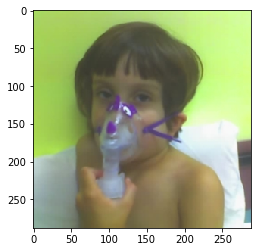

In [84]:
plt.figure()
plt.imshow(arr[5].astype('uint8'))

1261174 1261174


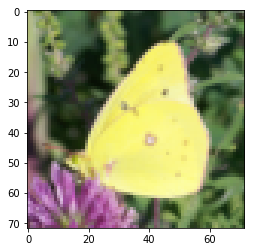

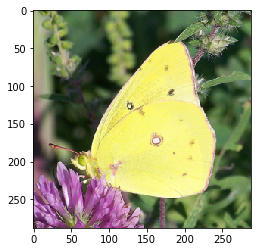

In [96]:
arr72 = bcolz.open('image_net_full_72.bc')
arr288 = bcolz.open('image_net_full_288.bc')
print(len(arr72), len(arr288))

def show_img(i):
    plt.figure()
    plt.imshow(arr72[i].astype('uint8'))
    plt.figure()
    plt.imshow(arr288[i].astype('uint8'))
    
show_img(1261173)